# Create data to perform Multiple Sequnce Alignment for fep system in Escherichia coli cohort

## Read `fep system` gene sequences

In [1]:
import os
from pathlib import Path

import pandas as pd

from Bio.SeqRecord import SeqRecord

from io import StringIO

geneNames = ['fhuA', 'fhuB', 'fhuC', 'fhuD'] # list obtained from this paper

fastaData = {}
gff3Path = Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 'e_coli', 'gff3_original')

dfList = []

for gff3FileName in os.listdir(gff3Path):

    gff3File = Path(gff3Path, gff3FileName)

    tubeId = gff3FileName.split('.')[0]

    gff3Lines = []
    fasta_start_index = None
    with open(gff3File, 'r') as in_handle:
        gff3Lines = in_handle.readlines()

    for i, line in enumerate(gff3Lines):
        if line.strip() == "##FASTA":
            fasta_start_index = i + 1
            break

    gff3Info = StringIO("".join(gff3Lines[: fasta_start_index]))

    df = pd.read_csv(gff3Info, sep='\t', comment='#', header=None, names=['seq_id', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])
    df['gene'] = df.attributes.str.split(';').apply(lambda x: [item.split('=')[1] for item in x if item.split('=')[0] == 'gene']).apply(lambda x: x[0] if x else None)
    df = df[df.gene.isin(geneNames)]
    df['tube_id'] = tubeId

    dfList.append(df)

allGenesDf = pd.concat(dfList, ignore_index=True)
allGenesDf

,seq_id,source,type,start,end,score,strand,phase,attributes,gene,tube_id
0,5,Prodigal,CDS,155747,157936,.,+,0,ID=EFLFLN_10210;Name=ferrichrome porin FhuA;lo...,fhuA,AH19A073
1,5,Prodigal,CDS,157987,158784,.,+,0,ID=EFLFLN_10215;Name=Fe3+-hydroxamate ABC tran...,fhuC,AH19A073
2,5,Prodigal,CDS,158784,159674,.,+,0,ID=EFLFLN_10220;Name=Fe(3+)-hydroxamate ABC tr...,fhuD,AH19A073
3,5,Prodigal,CDS,159671,161653,.,+,0,ID=EFLFLN_10225;Name=Fe(3+)-hydroxamate ABC tr...,fhuB,AH19A073
4,6,Prodigal,CDS,48897,50879,.,-,0,ID=DDMDOO_11950;Name=Fe(3+)-hydroxamate ABC tr...,fhuB,AH19F076
...,...,...,...,...,...,...,...,...,...,...,...
3440,4,Prodigal,CDS,282899,284881,.,+,0,ID=OFKMHD_08820;Name=Fe(3+)-hydroxamate ABC tr...,fhuB,AH19I058
3441,16,Prodigal,CDS,41510,43492,.,-,0,ID=GOAIKP_21035;Name=Fe(3+)-hydroxamate ABC tr...,fhuB,AH19K033
3442,16,Prodigal,CDS,43489,44379,.,-,0,ID=GOAIKP_21040;Name=Fe(3+)-hydroxamate ABC tr...,fhuD,AH19K033
3443,16,Prodigal,CDS,44379,45176,.,-,0,ID=GOAIKP_21045;Name=Fe3+-hydroxamate ABC tran...,fhuC,AH19K033


## Explore

In [2]:
allGenesDf.seq_id.value_counts()

seq_id
6      348
5      344
3      323
4      268
7      240
17     204
8      201
2      184
18     164
19     140
16     132
15     112
9      100
20      92
21      80
1       76
22      64
10      48
27      40
11      40
24      36
14      36
23      32
13      24
12      24
25      16
26      16
29      16
28      12
31       8
32       4
166      4
36       4
33       4
30       4
34       4
41       1
Name: count, dtype: int64

In [3]:
import pandas as pd
import numpy as np


pivotedGenesDf = pd.pivot_table(data=allGenesDf[['gene', 'tube_id']], columns='gene', index='tube_id', aggfunc=np.count_nonzero).fillna(0).astype(bool)
pivotedGenesDf

gene,fhuA,fhuB,fhuC,fhuD
tube_id,,,,
AH18J011,True,True,True,True
AH18J016,True,True,True,True
AH18J019,True,True,True,True
AH18J032,True,True,True,True
AH18J033,True,True,True,True
...,...,...,...,...
ALF23C186,True,True,True,True
ALF23C187,True,True,True,True
ALF23C213,True,True,True,True


In [4]:
pivotedGenesDf.reset_index(drop=True).sum()

gene
fhuA    860
fhuB    861
fhuC    861
fhuD    861
dtype: int64

In [5]:
groupedGenesDf = allGenesDf[allGenesDf.gene.isin(['fhuA', 'fhuB', 'fhuC', 'fhuD'])].groupby(by=['tube_id', 'gene'])['seq_id'].agg(list_of_contigs=lambda x: set(x)).reset_index()
groupedGenesDf.list_of_contigs.apply(lambda x: len(x)).value_counts()
# groupedGenesDf

list_of_contigs
1    3442
2       1
Name: count, dtype: int64

In [9]:
groupedGenesDf = groupedGenesDf[(groupedGenesDf.list_of_contigs.apply(lambda x: len(x)) == 1)]
groupedGenesDf.list_of_contigs.apply(lambda x: len(x)).value_counts()

list_of_contigs
1    3442
Name: count, dtype: int64

In [10]:
groupedGenesDf['contig'] = groupedGenesDf.list_of_contigs.apply(lambda x: list(x)[0])
groupedGenesDf

,tube_id,gene,list_of_contigs,contig
0,AH18J011,fhuA,{7},7
1,AH18J011,fhuB,{7},7
2,AH18J011,fhuC,{7},7
3,AH18J011,fhuD,{7},7
4,AH18J016,fhuA,{3},3
...,...,...,...,...
3438,ALF23C219,fhuD,{4},4
3439,ALF23C222,fhuA,{17},17
3440,ALF23C222,fhuB,{17},17
3441,ALF23C222,fhuC,{17},17


In [17]:
geneLocationsDf = groupedGenesDf.merge(
    allGenesDf[['seq_id', 'start', 'end', 'gene', 'tube_id']],
    how='inner',
    left_on=['tube_id', 'gene', 'contig'],
    right_on=['tube_id', 'gene', 'seq_id']
)[['tube_id', 'gene', 'contig', 'start', 'end']].groupby(
    by=['tube_id', 'gene', 'contig']
).agg('first').reset_index()
geneLocationsDf

,tube_id,gene,contig,start,end
0,AH18J011,fhuA,7,170672,172921
1,AH18J011,fhuB,7,174657,176639
2,AH18J011,fhuC,7,172973,173770
3,AH18J011,fhuD,7,173770,174660
4,AH18J016,fhuA,3,52850,55108
...,...,...,...,...,...
3437,ALF23C219,fhuD,4,50876,51766
3438,ALF23C222,fhuA,17,52551,54800
3439,ALF23C222,fhuB,17,48833,50815
3440,ALF23C222,fhuC,17,51702,52499


In [18]:
groupLocationsDf = geneLocationsDf.groupby(by=['tube_id', 'contig']).agg({'start': 'min', 'end': 'max'}).reset_index()
groupLocationsDf['seq_length'] = (groupLocationsDf.end - groupLocationsDf.start)
groupLocationsDf = groupLocationsDf[groupLocationsDf.seq_length > 5950]
groupLocationsDf

,tube_id,contig,start,end,seq_length
0,AH18J011,7,170672,176639,5967
1,AH18J016,3,49133,55108,5975
2,AH18J019,17,59881,65856,5975
3,AH18J032,2,160016,165991,5975
4,AH18J033,11,48840,54815,5975
...,...,...,...,...,...
856,ALF23C186,20,50965,56932,5967
857,ALF23C187,18,41510,47485,5975
858,ALF23C213,4,430107,436073,5966
859,ALF23C219,4,48897,54857,5960


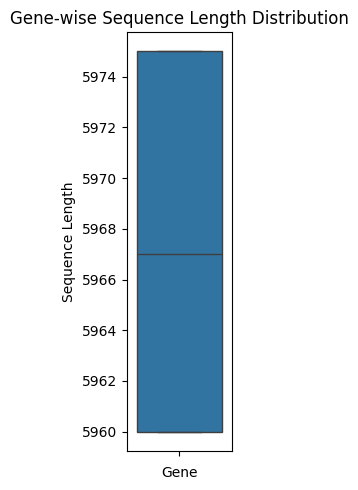

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have groupLocationsDf loaded as a DataFrame

# Group by gene and collect all sequence lengths
plt.figure(figsize=(2, 5))
sns.boxplot(data=groupLocationsDf, y="seq_length")

# Optional aesthetics
plt.xticks(rotation=45, ha='right')
plt.title("Gene-wise Sequence Length Distribution")
plt.xlabel("Gene")
plt.ylabel("Sequence Length")
plt.tight_layout()
plt.show()

## Function to obtain sequence

In [20]:
def getSequenceData(gff3Lines, fasta_start_index, seqId, startLocation, endLocation):

    from io import StringIO
    from Bio import SeqIO

    fasta_data = StringIO("".join(gff3Lines[fasta_start_index:]))
    seq_dict = SeqIO.to_dict(SeqIO.parse(fasta_data, "fasta"))

    return seq_dict[seqId][startLocation - 1:endLocation]

## Create FASTA data from location information

In [21]:
import os
from pathlib import Path

import pandas as pd

from Bio.SeqRecord import SeqRecord

from io import StringIO


fastaData = {}
gff3Path = Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 'e_coli', 'gff3_original')

dfList = []

for gff3FileName in os.listdir(gff3Path):

    gff3File = Path(gff3Path, gff3FileName)

    tubeId = gff3FileName.split('.')[0]

    gff3Lines = []
    fasta_start_index = None
    with open(gff3File, 'r') as in_handle:
        gff3Lines = in_handle.readlines()

    for i, line in enumerate(gff3Lines):
        if line.strip() == "##FASTA":
            fasta_start_index = i + 1
            break

    if(not groupLocationsDf[groupLocationsDf.tube_id == tubeId].empty):
        record = getSequenceData(
            gff3Lines=gff3Lines,
            fasta_start_index=fasta_start_index,
            seqId=str(groupLocationsDf[groupLocationsDf.tube_id == tubeId].contig.values[0]),
            startLocation=groupLocationsDf[groupLocationsDf.tube_id == tubeId].start.values[0],
            endLocation=groupLocationsDf[groupLocationsDf.tube_id == tubeId].end.values[0],
        )
        updatedRecord = SeqRecord(record.seq, id=tubeId, name=tubeId, description=tubeId)
        fastaData[tubeId] = updatedRecord


## Write fasta file

In [23]:
import os
from pathlib import Path

from Bio import SeqIO


SeqIO.write(fastaData.values(), Path(os.environ['GENOMICS_DATA_BASE'], 'annotations', 'e_coli', 'gene_sequences', 'fhu_system', 'sequence.fna'), 'fasta')

811